# Machine Learning: Classification - K-Nearest Neighbors (KNN)
## 1. Introduction
### 1.1 Definition
In machine learning, the _k-nearest neighbors algorithm_ (KNN) is a simple and non-parametric method used for classification and regression. In both cases, the input consists of the k-closest training examples in the feature space. The output depends on whether KNN is used for classification or regression:

In KNN classification, the output is a class membership. An object is classified by a plurality vote of its neighbors, with the object being assigned to the class most common among its k nearest neighbors (k is a positive integer, typically small). If k=1, then the object is simply assigned to the class of that single nearest neighbor. The challenge of modelling KNN algorithms is to find the best value for k. If k is too small it may capture to noise, while increasing too much will run into diminishing marginal returns on accuracy. Although conceptually simple, each additional iteration with k+1 will become computationally more intensive and take longer. 

| Example of KNN Classification |
|:-----------------------------:|
| ![image](https://upload.wikimedia.org/wikipedia/commons/e/e7/KnnClassification.svg "KNN Classification Example") |

The test sample (green dot) should be classified either to blue squares or to red triangles. If k=3 (solid circle) it is assigned to the red triangles because there are 2 triangles and only 1 square inside the inner circle. If k = 5 (dashed circle) it is assigned to the blue squares (3 squares vs. 2 triangles inside the outer circle).

### 1.2 Distance Metric

Since this algorithm relies on distance for classification, normalizing the training data can improve its accuracy dramatically. Common distance metrics used are Euclidian distance or Minkowski distance.

| Metric | Formula |
|--------|---------|
| Euclidean Distance | ![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/c28af99d6b7c1ff13d2b79347e90fec407aa9ef0 "Euclidian Distance") |
| Minkowski Distance | ![image](https://wikimedia.org/api/rest_v1/media/math/render/svg/4ed8b780e0d3224880760b1745c444481590ee86 "Minkowski Distance") |

https://en.wikipedia.org/wiki/K-nearest_neighbors_algorithm


This notebook will use the KNN classification algorithm from Scikit-Learn.

https://scikit-learn.org/stable/modules/generated/sklearn.neighbors.NearestNeighbors.html

## 2. KNN Classification on Random Data
### 2.1 Generating a Random Dataset
In order to demonstrate KNN classification, the function below will be employed to generate a random dataset with 3 classes. It requires the following inputs:
- n_samples: total number of points equally divided among clusters
  - value will be: 600
- centers: number of centers to generate, or the fixed center locations
  - value will be: 3
- cluster_std: standard deviation of the clusters (spread of the points from cluster centriod)
  - value will be: 3

This will produce the following output:
- X: array of shape [n_samples, n_features] a.k.a. Feature Matrix
- y: array of shape [n_samples] a.k.a. Response Vector
  - the integer labels for cluster membership of each sample

In [1]:
from sklearn.datasets import make_blobs
X, y = make_blobs(n_samples=600, centers=3, random_state=3, cluster_std=3)
print(X[0:5])
print(y[0:5])

[[-2.14002436 -1.79195622]
 [ 6.17438772 -2.91468776]
 [-8.70099358 -0.10684484]
 [-2.5556782   1.18884027]
 [ 2.85818931  1.64921963]]
[1 0 1 1 0]


### 2.2 Visualizing the Random Dataset

In [2]:
import numpy as np
from numpy import where
import matplotlib as mlp
from matplotlib import pyplot as plt
import seaborn as sns
%matplotlib inline

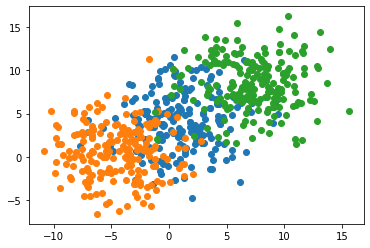

In [3]:
# plot the data
for class_value in range(3):
    # get row indexes for samples with this class
    row_ix = where(y == class_value)
    # create scatter of these samples
    plt.scatter(X[row_ix, 0], X[row_ix, 1])

plt.show()

### 2.3 Data Pre-Processing
Data Standardization gives data zero mean and unit variance, which is good practice, especially for algorithms such as KNN which is based on distance of cases.

Moreover, the dataset will be split into training and testing subsets for later evaluation purposes.

In [4]:
# normalize the data
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:3]

array([[-0.60904503, -1.3920493 ],
       [ 0.87938629, -1.64544725],
       [-1.78357811, -1.01172351]])

In [5]:
# split dataset into training and testing subsets
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=4)

print ('Train set:', X_train.shape)
print ('Test set:', X_test.shape)

Train set: (480, 2)
Test set: (120, 2)


### 2.4 Modelling and Evaluating KNN
As mentioned before, the challenge of building a KNN classificaiton model is finding a good k-values, i.e. the number of neighbors for comparison. The k-value must be set manually. Rather than testing each k-value for itself, a _for loop_ can used to test range of k-values and find the one with best accuracy.

In [6]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics

# determine a reasonable range for k, also create objects for mean and standard deviation of accuarcy
Ks = 10
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

# train the model by iterating through the range of pre-specified k values
for n in range(1,Ks):
    
    # train model and predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    # store accuarcy measures
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)  
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.78333333, 0.79166667, 0.79166667, 0.8       , 0.825     ,
       0.80833333, 0.81666667, 0.79166667, 0.8       ])

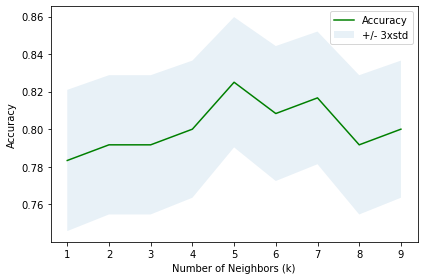

The best accuracy was at 0.825 with k= 5


In [7]:
# visualize the accuracy scores and print the best k-value
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()

print( "The best accuracy was at", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

## 3. KNN Classification on Real-World Data
### 3.1 The Goal and the Dataset
Imagine a telecommunications provider has segmented its customer base by service usage patterns, categorizing the customers into four groups. If demographic data can be used to predict group membership, the company can customize offers for individual prospective customers. This is a classification problem. The example will focus on using demographic data, such as region, age, and marital status to predict usage patterns/customer category.

The target field, called custcat, has four possible values that correspond to the four customer groups, as follows:
1. Basic Service
2. E-Service
3. Plus Service
4. Total Service

In [8]:
# download the dataset from IBM storage
!wget -O teleCust1000t.csv https://s3-api.us-geo.objectstorage.softlayer.net/cf-courses-data/CognitiveClass/ML0101ENv3/labs/teleCust1000t.csv
print("Dataset downloaded.")

Dataset downloaded.


In [9]:
# read the dataset into a Pandas dataframe
import pandas as pd
df = pd.read_csv('teleCust1000t.csv')
print(df.shape)
df.head()

(1000, 12)


,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
0,2,13,44,1,9,64.0,4,5,0.0,0,2,1
1,3,11,33,1,7,136.0,5,5,0.0,0,6,4
2,3,68,52,1,24,116.0,1,29,0.0,1,2,3
3,2,33,33,0,12,33.0,2,0,0.0,1,1,1
4,2,23,30,1,9,30.0,1,2,0.0,0,4,3


### 3.2 Visualizations for Exploratory Data Analysis
Exploratory data analysis (EDA) is the processes of gaining preliminary insights on a dataset before data mining. Summary statistics and data visualization is common tool of EDA to observe the distribution of features in a dataset.

In [10]:
# obtain descriptive/summary statistics on the dataset
df.describe()

,region,tenure,age,marital,address,income,ed,employ,retire,gender,reside,custcat
count,1000.0000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000,1000.000000
mean,2.0220,35.526000,41.684000,0.495000,11.551000,77.535000,2.671000,10.987000,0.047000,0.517000,2.331000,2.487000
std,0.8162,21.359812,12.558816,0.500225,10.086681,107.044165,1.222397,10.082087,0.211745,0.499961,1.435793,1.120306
min,1.0000,1.000000,18.000000,0.000000,0.000000,9.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000
25%,1.0000,17.000000,32.000000,0.000000,3.000000,29.000000,2.000000,3.000000,0.000000,0.000000,1.000000,1.000000
50%,2.0000,34.000000,40.000000,0.000000,9.000000,47.000000,3.000000,8.000000,0.000000,1.000000,2.000000,3.000000
75%,3.0000,54.000000,51.000000,1.000000,18.000000,83.000000,4.000000,17.000000,0.000000,1.000000,3.000000,3.000000
max,3.0000,72.000000,77.000000,1.000000,55.000000,1668.000000,5.000000,47.000000,1.000000,1.000000,8.000000,4.000000


<AxesSubplot:>

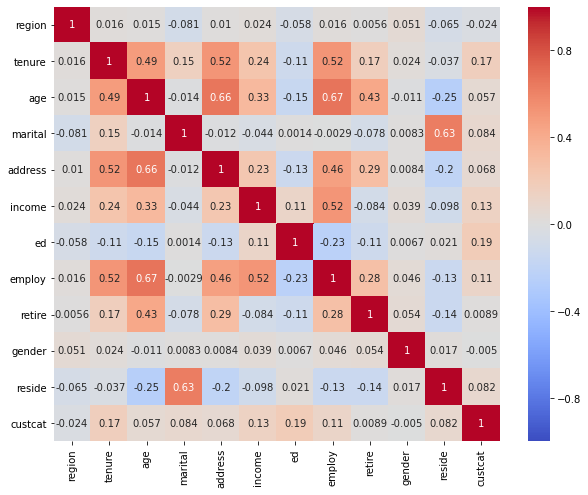

In [11]:
# obtain correlation heatmap
plt.figure(figsize=(10,8))
sns.heatmap(df.corr(), annot = True, vmin=-1, vmax=1, cmap= 'coolwarm')

In [12]:
# how many customers are in each category?
df['custcat'].value_counts()

3    281
1    266
4    236
2    217
Name: custcat, dtype: int64

<AxesSubplot:xlabel='custcat', ylabel='income'>

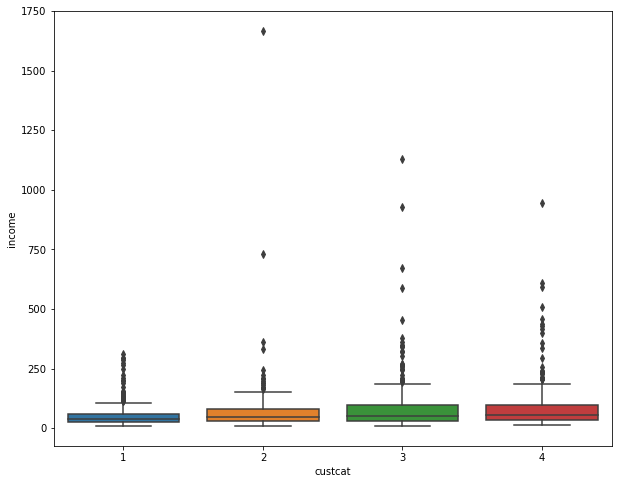

In [13]:
plt.figure(figsize=(10,8))
sns.boxplot(y='income', x='custcat', data=df)

array([[<AxesSubplot:title={'center':'income'}>]], dtype=object)

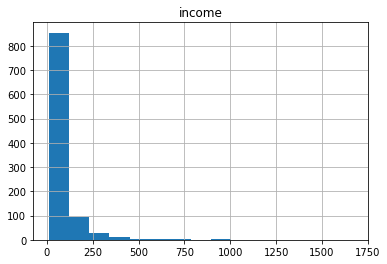

In [14]:
df.hist(column='income', bins=15)

array([[<AxesSubplot:title={'center':'age'}>]], dtype=object)

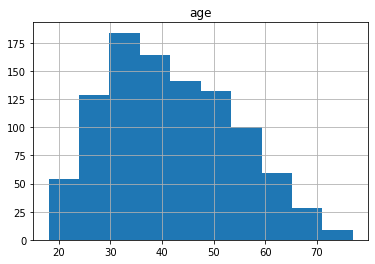

In [15]:
df.hist(column='age', bins=10)

array([[<AxesSubplot:title={'center':'ed'}>]], dtype=object)

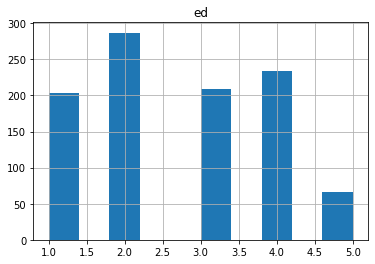

In [16]:
df.hist(column='ed')

### 3.3 Feature Selection and Data Pre-Processing
In this section, the relevant features for classification will be selected for the classification model as well as processes and standardized for the ML algorithm. Fortunately, the dataset comes with many continuous features, which speeds up the pre-processing.

In [17]:
# create a feature set X
X = df[['region', 'tenure', 'age', 'marital', 'income', 'ed', 'employ']] .values  #.astype(float)
# create a target label
y = df['custcat'].values

print(X[0:3])
print(y[0:3])

[[  2.  13.  44.   1.  64.   4.   5.]
 [  3.  11.  33.   1. 136.   5.   5.]
 [  3.  68.  52.   1. 116.   1.  29.]]
[1 4 3]


In [18]:
# data standardization
from sklearn import preprocessing
X = preprocessing.StandardScaler().fit(X).transform(X.astype(float))
X[0:3]

array([[-0.02696767, -1.055125  ,  0.18450456,  1.0100505 , -0.12650641,
         1.0877526 , -0.5941226 ],
       [ 1.19883553, -1.14880563, -0.69181243,  1.0100505 ,  0.54644972,
         1.9062271 , -0.5941226 ],
       [ 1.19883553,  1.52109247,  0.82182601,  1.0100505 ,  0.35951747,
        -1.36767088,  1.78752803]])

In [19]:
# split the dataset into training and testing subset
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X, y, test_size=0.2, random_state=2)

print ('Train set:', X_train.shape)
print ('Test set:', X_test.shape)

Train set: (800, 7)
Test set: (200, 7)


### 3.4 Modelling and Evaluating KNN
The modelling and evaluation of the KNN model for tele-customer dataset will follow the same principles as in the chapter before. A _for loop_ is used to iterate through a range of k-values to determine which is best for the dataset.  

In [20]:
# determine a reasonable range for k, also create objects for mean and standard deviation of accuarcy
import numpy as np
from sklearn.neighbors import KNeighborsClassifier
from sklearn import metrics
Ks = 25
mean_acc = np.zeros((Ks-1))
std_acc = np.zeros((Ks-1))

# train the model by iterating through the range of pre-specified k values
for n in range(1,Ks):
    
    # train model and predict  
    neigh = KNeighborsClassifier(n_neighbors = n).fit(X_train,y_train)
    yhat=neigh.predict(X_test)
    # store accuarcy measures
    mean_acc[n-1] = metrics.accuracy_score(y_test, yhat)  
    std_acc[n-1]=np.std(yhat==y_test)/np.sqrt(yhat.shape[0])

mean_acc

array([0.25 , 0.275, 0.31 , 0.295, 0.32 , 0.325, 0.36 , 0.38 , 0.365,
       0.355, 0.37 , 0.345, 0.375, 0.375, 0.385, 0.39 , 0.355, 0.37 ,
       0.36 , 0.365, 0.35 , 0.355, 0.345, 0.345])

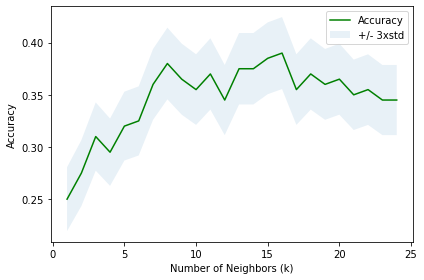

The best accuracy was with 0.39 with k= 16


In [21]:
# visualize the accuracy scores and print the best k-value
import matplotlib as mpl
import matplotlib as mlp
from matplotlib import pyplot as plt
%matplotlib inline
plt.plot(range(1,Ks),mean_acc,'g')
plt.fill_between(range(1,Ks),mean_acc - 1 * std_acc,mean_acc + 1 * std_acc, alpha=0.10)
plt.legend(('Accuracy', '+/- 3xstd'))
plt.ylabel('Accuracy')
plt.xlabel('Number of Neighbors (k)')
plt.tight_layout()
plt.show()

print( "The best accuracy was with", mean_acc.max(), "with k=", mean_acc.argmax()+1) 

On real-world data, the KNN accuracy is more eratic with varying k-values but still shows that a too low k captures too much noise, while a higher k is at risk of diminished returns on accuracy. Although the KNN classification algorithm has not achieved satisfactory accuracy in this example, the assumption about it hold true on real world data.